## Chapter 08: Sequence to sequence models


In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [2]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)


Some tests

In [3]:
voc = Vocabulary()

assert(voc.add_token('a') == 0)
assert(voc.add_token('b') == 1)
assert(voc.add_token('a') == 0)
assert(voc.lookup_index(0) == 'a')
assert(voc.lookup_token('a') == 0)

## Sequence Vocabulary

This subclass of `Vocabulary` adds 4 tokens:
- `<UNK>`
- `<BEGIN>`
- `<END>`
- `<MASK>`

In [4]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]


In [5]:
voc = SequenceVocabulary()

assert(voc.mask_index is not None)
assert(voc.unk_index is not None)
assert(voc.begin_seq_index is not None)
assert(voc.end_seq_index is not None)

a_idx = voc.add_token('a')
assert(a_idx is not None)
assert(voc.lookup_token('a') == a_idx)
assert(voc.lookup_token('b') == voc.unk_index)

## Dataset

Let's checkout what the data looks like

In [6]:
bitext_df = pd.read_csv("data/nmt/simplest_eng_fra.csv")

bitext_df[:10]

,Unnamed: 0,source_language,split,target_language
0,0,he 's the cutest boy in town .,train,c'est le garçon le plus mignon en ville .
1,1,he 's a nonsmoker .,train,il est non-fumeur .
2,2,he 's smarter than me .,train,il est plus intelligent que moi .
3,3,he 's a lovely young man .,train,c'est un adorable jeune homme .
4,4,he 's three years older than me .,train,il a trois ans de plus que moi .
5,5,he 's washing your car .,train,il lave votre voiture .
6,6,he 's your typical workaholic .,train,"il est l'archétype du bourreau de travail , te..."
7,7,he 's waiting for you at home .,train,il t'attend chez nous .
8,8,he 's a historian .,train,il est historien .
9,9,he 's studying .,train,il étudie .


## Vectorizer

The `NMTVectorizer` class is more complex than its previous versions: we need one vectorization for the source language, and another for the target language.

In [7]:
class NMTVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""        
    def __init__(self, source_vocab, target_vocab, max_source_length, max_target_length):
        """
        Args:
            source_vocab (SequenceVocabulary): maps source words to integers
            target_vocab (SequenceVocabulary): maps target words to integers
            max_source_length (int): the longest sequence in the source dataset
            max_target_length (int): the longest sequence in the target dataset
        """
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        

    def _vectorize(self, indices, vector_length=-1, mask_index=0):
        """Vectorize the provided indices
        
        Args:
            indices (list): a list of integers that represent a sequence
            vector_length (int): an argument for forcing the length of index vector
            mask_index (int): the mask_index to use; almost always 0
        """
        if vector_length < 0:
            vector_length = len(indices)
        
        vector = np.zeros(vector_length, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = mask_index

        return vector
    
    def _get_source_indices(self, text):
        """Return the vectorized source text
        
        Args:
            text (str): the source text; tokens should be separated by spaces
        Returns:
            indices (list): list of integers representing the text
        """
        indices = [self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token) for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices
    
    def _get_target_indices(self, text):
        """Return the vectorized source text
        
        Args:
            text (str): the source text; tokens should be separated by spaces
        Returns:
            a tuple: (x_indices, y_indices)
                x_indices (list): list of integers representing the observations in target decoder 
                y_indices (list): list of integers representing predictions in target decoder
        """
        indices = [self.target_vocab.lookup_token(token) for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab.end_seq_index]
        return x_indices, y_indices
        
    def vectorize(self, source_text, target_text, use_dataset_max_lengths=True):
        """Return the vectorized source and target text
        
        The vetorized source text is just the a single vector.
        The vectorized target text is split into two vectors in a similar style to 
            the surname modeling in Chapter 7.
        At each timestep, the first vector is the observation and the second vector is the target. 
        
        
        Args:
            source_text (str): text from the source language
            target_text (str): text from the target language
            use_dataset_max_lengths (bool): whether to use the global max vector lengths
        Returns:
            The vectorized data point as a dictionary with the keys: 
                source_vector, target_x_vector, target_y_vector, source_length
        """
        source_vector_length = -1
        target_vector_length = -1
        
        if use_dataset_max_lengths:
            source_vector_length = self.max_source_length + 2
            target_vector_length = self.max_target_length + 1

        source_indices = self._get_source_indices(source_text)
        source_vector = self._vectorize(source_indices, 
                                        vector_length=source_vector_length, 
                                        mask_index=self.source_vocab.mask_index)
        
        target_x_indices, target_y_indices = self._get_target_indices(target_text)
        target_x_vector = self._vectorize(target_x_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        target_y_vector = self._vectorize(target_y_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        return {"source_vector": source_vector, 
                "target_x_vector": target_x_vector, 
                "target_y_vector": target_y_vector, 
                "source_length": len(source_indices)}
        
    @classmethod
    def from_dataframe(cls, bitext_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            bitext_df (pandas.DataFrame): the parallel text dataset
        Returns:
            an instance of the NMTVectorizer
        """
        source_vocab = SequenceVocabulary()
        target_vocab = SequenceVocabulary()
        
        max_source_length = 0
        max_target_length = 0

        for _, row in bitext_df.iterrows():
            source_tokens = row["source_language"].split(" ")
            if len(source_tokens) > max_source_length:
                max_source_length = len(source_tokens)
            for token in source_tokens:
                source_vocab.add_token(token)
            
            target_tokens = row["target_language"].split(" ")
            if len(target_tokens) > max_target_length:
                max_target_length = len(target_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)
            
        return cls(source_vocab, target_vocab, max_source_length, max_target_length)

    @classmethod
    def from_serializable(cls, contents):
        source_vocab = SequenceVocabulary.from_serializable(contents["source_vocab"])
        target_vocab = SequenceVocabulary.from_serializable(contents["target_vocab"])
        
        return cls(source_vocab=source_vocab, 
                   target_vocab=target_vocab, 
                   max_source_length=contents["max_source_length"], 
                   max_target_length=contents["max_target_length"])

    def to_serializable(self):
        return {"source_vocab": self.source_vocab.to_serializable(), 
                "target_vocab": self.target_vocab.to_serializable(), 
                "max_source_length": self.max_source_length,
                "max_target_length": self.max_target_length}

Some tests!

In [8]:
source_vocab = SequenceVocabulary()
target_vocab = SequenceVocabulary()

source_vocab.add_many(['a', 'b', 'c'])
target_vocab.add_many(['d', 'e', 'f'])

vectorizer = NMTVectorizer(
    source_vocab, 
    target_vocab, 
    max_source_length=10, 
    max_target_length=10)

ret = vectorizer.vectorize("a b a c a a", "d e f f")

print("Source vector: ", [source_vocab.lookup_index(t) for t in ret["source_vector"]] )
print("From Vector: ", [target_vocab.lookup_index(t) for t in ret["target_x_vector"]])
print("To Vector: ", [target_vocab.lookup_index(t) for t in ret["target_y_vector"]])


Source vector:  ['<BEGIN>', 'a', 'b', 'a', 'c', 'a', 'a', '<END>', '<MASK>', '<MASK>', '<MASK>', '<MASK>']
From Vector:  ['<BEGIN>', 'd', 'e', 'f', 'f', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>']
To Vector:  ['d', 'e', 'f', 'f', '<END>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>']


## Dataset

In [9]:
class NMTDataset(Dataset):
    def __init__(self, text_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.text_df = text_df
        self._vectorizer = vectorizer

        self.train_df = self.text_df[self.text_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.text_df[self.text_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.text_df[self.text_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, dataset_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        text_df = pd.read_csv(dataset_csv)
        train_subset = text_df[text_df.split=='train']
        return cls(text_df, NMTVectorizer.from_dataframe(train_subset))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, dataset_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        text_df = pd.read_csv(dataset_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(text_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return NMTVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point: (x_data, y_target, class_index)
        """
        row = self._target_df.iloc[index]

        vector_dict = self._vectorizer.vectorize(row.source_language, row.target_language)

        return {"x_source": vector_dict["source_vector"], 
                "x_target": vector_dict["target_x_vector"],
                "y_target": vector_dict["target_y_vector"], 
                "x_source_length": vector_dict["source_length"]}
        
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

In [10]:
dataset = NMTDataset.load_dataset_and_make_vectorizer(
    "data/nmt/simplest_eng_fra.csv")

vectorizer = dataset.get_vectorizer()

In [11]:
dataset.set_split('train')

train_0 = dataset[0]

dataset.set_split('test')

test_0 = dataset[0]

train_0.keys(), test_0.keys()

(dict_keys(['x_source', 'x_target', 'y_target', 'x_source_length']),
 dict_keys(['x_source', 'x_target', 'y_target', 'x_source_length']))

Now, we change slightly this version of generate batches to use `PackedSequences`

In [12]:
def generate_nmt_batches(dataset, batch_size, shuffle=True, 
                            drop_last=True, device="cpu"):
    """A generator function which wraps the PyTorch DataLoader.  The NMT Version """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict




## Packing Sequences

![image](images/packed_sequences.png)


Using the standard padding approach for Recurrent Neural Networks might lead to inefficient computation. For instance, using a Vanilla RNN in the image of the left would need `4 * 3 = 12` matrix products, but we just needed `8`.

To deal with this, PyTorch uses Packed Sequences, which increases computational efficiency. There are two prerequisites for creating a `PackedSequence`: knowing the length of each sequence, and sorting the sequences in descending order by the length of the source sequence. To reflect this newly sorted matrix, the remaining tensors in the minibatch are sorted in the same order so that they stay aligned with the source sequence encoding

Let's create a sample for this mechanism: create a padded tensor with its respective lengths, an Embedding Matrix and a RNN layer

In [13]:
X = torch.LongTensor([
    [4, 3, 2, 1],
    [4, 3, 2, 0],
    [4, 0, 0, 0],
])
lengths = torch.LongTensor([4, 3, 1])


embedding_size = 7
hidden_size = 15
embedding = nn.Embedding(5, embedding_size, padding_idx=0)
rnn = nn.GRU(embedding_size, hidden_size, batch_first=True)



Now, let's retrieve the embeddings and pack the sequence

In [14]:

embeddings = embedding(X)
x_packed = pack_padded_sequence(embeddings, lengths, batch_first=True)

x_packed

PackedSequence(data=tensor([[-0.9653,  0.9017,  0.8593,  0.0820, -1.0549,  0.4161, -0.8323],
        [-0.9653,  0.9017,  0.8593,  0.0820, -1.0549,  0.4161, -0.8323],
        [-0.9653,  0.9017,  0.8593,  0.0820, -1.0549,  0.4161, -0.8323],
        [-1.8801,  0.6905,  0.0264,  1.2107,  1.1427, -0.6073, -0.5944],
        [-1.8801,  0.6905,  0.0264,  1.2107,  1.1427, -0.6073, -0.5944],
        [ 0.4551, -0.2669,  0.7542, -1.5800,  0.3235, -1.1966, -0.3281],
        [ 0.4551, -0.2669,  0.7542, -1.5800,  0.3235, -1.1966, -0.3281],
        [-1.3592, -0.6524, -0.4753,  0.2728, -0.8041,  0.0929, -0.1929]],
       grad_fn=<PackPaddedSequenceBackward>), batch_sizes=tensor([3, 2, 2, 1]))

Apply the RNN layer

In [15]:

x_out, h = rnn(x_packed)

type(x_out), h.shape

(torch.nn.utils.rnn.PackedSequence, torch.Size([1, 3, 15]))

The [nn.GRU](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU) layer returns the following:
```
1. output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features h_t from the last layer of the GRU, for each t. If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence. 
2. h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len

Like output, the layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size).
```

So, let's unpack the sequence

In [16]:

# Unpack!
x_unpacked, _lengths = pad_packed_sequence(x_out, batch_first=True)

# (batch_size, max_len, embedding_size)
x_unpacked.shape

torch.Size([3, 4, 15])

Now, the `h` has shape `(1, batch_size, hidden_size)` => we want it like `batch_size, hidden_size` 

In [17]:

new_h = h.permute(1, 0, 2)
new_h = new_h.contiguous().view(new_h.size(0), -1)

new_h.shape

torch.Size([3, 15])

**NOTE**: Why not just use squeeze?

In [18]:
torch.eq(h.squeeze(0), new_h)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

## NMT Encoder

In [19]:
class NMTEncoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        """
        Args:
            num_embeddings (int): number of embeddings is the size of source vocabulary
            embedding_size (int): size of the embedding vectors
            rnn_hidden_size (int): size of the RNN hidden state vectors 
        """
        super(NMTEncoder, self).__init__()
    
        self.source_embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x_source, x_lengths):
        """The forward pass of the model
        
        Args:
            x_source (torch.Tensor): the input data tensor.
                x_source.shape is (batch, seq_size)
            x_lengths (torch.Tensor): a vector of lengths for each item in the batch
        Returns:
            a tuple: x_unpacked (torch.Tensor), x_birnn_h (torch.Tensor)
                x_unpacked.shape = (batch, seq_size, rnn_hidden_size * 2)
                x_birnn_h.shape = (batch, rnn_hidden_size * 2)
        """
        x_embedded = self.source_embedding(x_source)
        # create PackedSequence; x_packed.data.shape=(number_items, embeddign_size)
        x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(), 
                                        batch_first=True)
        
        # x_birnn_h.shape = (num_rnn, batch_size, feature_size)
        x_birnn_out, x_birnn_h  = self.birnn(x_packed)
        # permute to (batch_size, num_rnn, feature_size)
        x_birnn_h = x_birnn_h.permute(1, 0, 2)
        
        # flatten features; reshape to (batch_size, num_rnn * feature_size)
        #  (recall: -1 takes the remaining positions, 
        #           flattening the two RNN hidden vectors into 1)
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1)
        
        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        
        return x_unpacked, x_birnn_h

In [20]:
encoder = NMTEncoder(num_embeddings=3, embedding_size=10, rnn_hidden_size=5)

X = torch.LongTensor([
    [1, 2, 1],
    [1, 1, 0],
])
lens = torch.LongTensor([3, 2])
x_unpacked, x_birnn_h = encoder(X, lens)

# 2 = batch, 3 = len, 10 = embedding size
# Para el birnn => 1 por el batch size, 10 por 2*rnn_hidden_size
x_unpacked.shape, x_birnn_h.shape

(torch.Size([2, 3, 10]), torch.Size([2, 10]))

## Attention Mechanisms

Primero, verbose attention. Dada la matriz de estados $V$ y $Q$ matriz de queries, calcula scores

$$
S = V Q
$$

y luego las probabilidades

$$
P = softmax(S)
$$

In [21]:
def verbose_attention(encoder_state_vectors, query_vector):
    """A descriptive version of the neural attention mechanism 
    
    Args:
        encoder_state_vectors (torch.Tensor): 3dim tensor from bi-GRU in encoder
        query_vector (torch.Tensor): hidden state in decoder GRU
    Returns:
        
    """
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    vector_scores = torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), 
                              dim=2)
    vector_probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1)
    context_vectors = torch.sum(weighted_vectors, dim=1)
    return context_vectors, vector_probabilities, vector_scores


In [22]:

def terse_attention(encoder_state_vectors, query_vector):
    """A shorter and more optimized version of the neural attention mechanism
    
    Args:
        encoder_state_vectors (torch.Tensor): 3dim tensor from bi-GRU in encoder
        query_vector (torch.Tensor): hidden state
    """
    vector_scores = torch.matmul(encoder_state_vectors, query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), 
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, vector_probabilities

## NMTDecoder

In [23]:
class NMTDecoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        """
        Args:
            num_embeddings (int): number of embeddings is also the number of 
                unique words in target vocabulary 
            embedding_size (int): the embedding vector size
            rnn_hidden_size (int): size of the hidden rnn state
            bos_index(int): begin-of-sequence index
        """
        super(NMTDecoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_size, 
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        self.bos_index = bos_index
    
    def _init_indices(self, batch_size):
        """ return the BEGIN-OF-SEQUENCE index vector """
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    def _init_context_vectors(self, batch_size):
        """ return a zeros vector for initializing the context """
        return torch.zeros(batch_size, self._rnn_hidden_size)
            
    def forward(self, encoder_state, initial_hidden_state, target_sequence):
        """The forward pass of the model
        
        Args:
            encoder_state (torch.Tensor): the output of the NMTEncoder
            initial_hidden_state (torch.Tensor): The last hidden state in the  NMTEncoder
            target_sequence (torch.Tensor): the target text data tensor
        Returns:
            output_vectors (torch.Tensor): prediction vectors at each output step
        """    
        # We are making an assumption there: The batch is on first
        # The input is (Batch, Seq)
        # We want to iterate over sequence so we permute it to (S, B)
        target_sequence = target_sequence.permute(1, 0)
        output_sequence_size = target_sequence.size(0)

        # use the provided encoder hidden state as the initial hidden state
        h_t = self.hidden_map(initial_hidden_state)

        batch_size = encoder_state.size(0)
        # initialize context vectors to zeros
        context_vectors = self._init_context_vectors(batch_size)
        # initialize first y_t word as BOS
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        for i in range(output_sequence_size):
            y_t_index = target_sequence[i]
                
            # Step 1: Embed word and concat with previous context
            y_input_vector = self.target_embedding(y_t_index)
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)
            
            # Step 2: Make a GRU step, getting a new hidden vector
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            # Step 3: Use the current hidden to attend to the encoder state
            context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state, 
                                                           query_vector=h_t)
            
            # auxillary: cache the attention probabilities for visualization
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            # Step 4: Use the current hidden and context vectors to make a prediction to the next word
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            # We don't apply softmax to use the proper loss
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            # auxiliary: collect the prediction scores
            output_vectors.append(score_for_y_t_index)
            
        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)
        
        return output_vectors

In [24]:
encoder = NMTEncoder(num_embeddings=3, embedding_size=10, rnn_hidden_size=5)
# Decoder must have hidden size two times bigger than encoder because it's consuming 
# the last hidden state of a biRNN
decoder = NMTDecoder(num_embeddings=4, embedding_size=10, rnn_hidden_size=10, bos_index=1)

X = torch.LongTensor([
    [1, 2, 1],
    [1, 1, 0],
])
lens = torch.LongTensor([3, 2])
x_unpacked, x_birnn_h = encoder(X, lens)

# 2 = batch, 3 = len, 10 = embedding size
# Para el birnn => 1 por el batch size, 10 por 2*rnn_hidden_size
x_unpacked.shape, x_birnn_h.shape

target_sequence =  torch.LongTensor([
    [1, 2, 2, 2, 2],
    [1, 2, 2, 2, 0],
])

decoder(x_unpacked, x_birnn_h, target_sequence)

tensor([[[-0.0747,  0.4391,  0.0857, -0.2253],
         [-0.0442,  0.3716, -0.2771, -0.2311],
         [-0.0238,  0.1717, -0.2207, -0.4668],
         [ 0.0048,  0.6278, -0.3204, -0.0940],
         [-0.0255,  0.4295, -0.5517, -0.2333]],

        [[-0.0907,  0.3308,  0.0536, -0.0346],
         [ 0.0100,  0.1868, -0.1358, -0.1194],
         [-0.1999,  0.2913, -0.2925, -0.2031],
         [-0.2666,  0.2033, -0.3526, -0.2364],
         [ 0.0515,  0.3180, -0.2850,  0.0932]]], grad_fn=<PermuteBackward>)

## NMTModel

This is the model gluing together the encoder and decoder

In [25]:
class NMTModel(nn.Module):
    """ The Neural Machine Translation Model """
    def __init__(self, source_vocab_size, source_embedding_size, 
                 target_vocab_size, target_embedding_size, encoding_size, 
                 target_bos_index):
        """
        Args:
            source_vocab_size (int): number of unique words in source language
            source_embedding_size (int): size of the source embedding vectors
            target_vocab_size (int): number of unique words in target language
            target_embedding_size (int): size of the target embedding vectors
            encoding_size (int): the size of the encoder RNN.  
        """
        super(NMTModel, self).__init__()
        self.encoder = NMTEncoder(num_embeddings=source_vocab_size, 
                                  embedding_size=source_embedding_size,
                                  rnn_hidden_size=encoding_size)
        decoding_size = encoding_size * 2
        self.decoder = NMTDecoder(num_embeddings=target_vocab_size, 
                                  embedding_size=target_embedding_size, 
                                  rnn_hidden_size=decoding_size,
                                  bos_index=target_bos_index)
    
    def forward(self, x_source, x_source_lengths, target_sequence):
        """The forward pass of the model
        
        Args:
            x_source (torch.Tensor): the source text data tensor. 
                x_source.shape should be (batch, vectorizer.max_source_length)
            x_source_lengths torch.Tensor): the length of the sequences in x_source 
            target_sequence (torch.Tensor): the target text data tensor
        Returns:
            decoded_states (torch.Tensor): prediction vectors at each output step
        """
        encoder_state, final_hidden_states = self.encoder(x_source, x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state, 
                                      initial_hidden_state=final_hidden_states, 
                                      target_sequence=target_sequence)
        return decoded_states

## Training

```python
args = Namespace(dataset_csv="data/nmt/simplest_eng_fra.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model.pth",
                 save_dir="model_storage/ch8/nmt_luong_no_sampling",
                 reload_from_files=True,
                 expand_filepaths_to_save_dir=True,
                 cuda=False,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=64,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=64, 
                 target_embedding_size=64,
                 encoding_size=64,
                 catch_keyboard_interrupt=True)
```

In [33]:
from tqdm import tqdm_notebook

batch_size = 64
num_epochs = 100
learning_rate = 5e-4
early_stopping_criteria=5

train_state = {
    'stop_early': False,
    'early_stopping_step': 0,
    'early_stopping_best_val': 1e8,
    'learning_rate': 0.001,
    'epoch_index': 0,
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'test_loss': -1,
    'test_acc': -1,    
}



epoch_bar = tqdm_notebook(desc='training routine', 
                          total=num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(batch_size), 
                        position=1, 
                        leave=True)


In [34]:
def normalize_sizes(y_pred, y_true):
    """Normalize tensor sizes
    
    Args:
        y_pred (torch.Tensor): the output of the model
            If a 3-dimensional tensor, reshapes to a matrix
        y_true (torch.Tensor): the target predictions
            If a matrix, reshapes to be a vector
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [35]:
dataset = NMTDataset.load_dataset_and_make_vectorizer(
    "data/nmt/simplest_eng_fra.csv")

vectorizer = dataset.get_vectorizer()

In [36]:
model = NMTModel(
    source_vocab_size=len(vectorizer.source_vocab), 
    source_embedding_size=64, 
    target_vocab_size=len(vectorizer.target_vocab),
    target_embedding_size=64, 
    encoding_size=64,
    target_bos_index=vectorizer.target_vocab.begin_seq_index)

In [37]:

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index


Now yes, let's train

In [56]:
try:
    for epoch_index in range(num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=batch_size)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=batch_size, 
                                               device="cpu")
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the running loss and accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        
        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'] )
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

Exiting loop


In [57]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

In [58]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
    
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'], 
                            x_source_lengths=batch_dict['x_source_length'], 
                            target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)

    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [59]:
model = model.eval()

sampler = NMTSampler(vectorizer, model)

dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=batch_size, )

test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(0.4949414323101704, 0.49881572779181316)

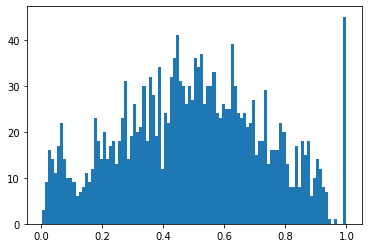

In [60]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

In [61]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=batch_size)
batch_dict = next(batch_generator)

model = model.eval()
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [62]:
all_results = []
for i in range(batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [63]:

top_results = [x for x in all_results if x['bleu-4']>0.1]
len(top_results)

59

/home/jmperez/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


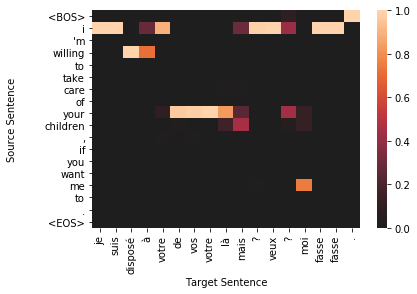

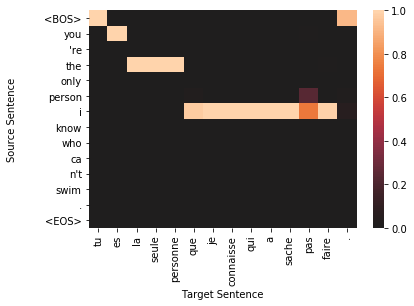

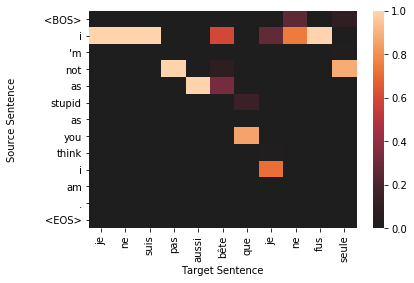

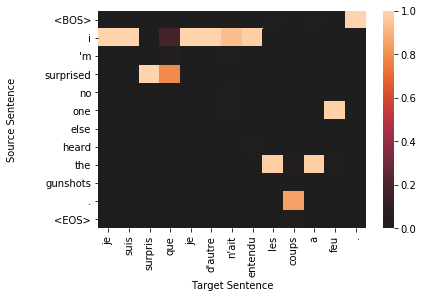

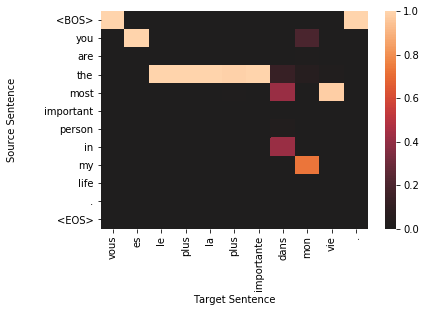

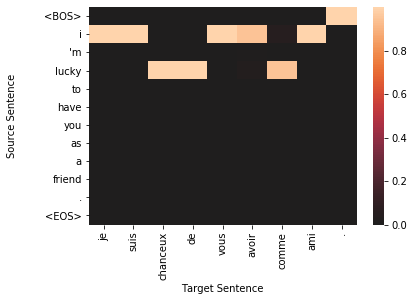

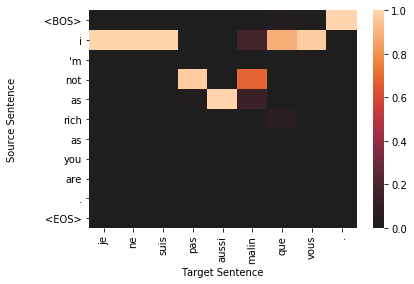

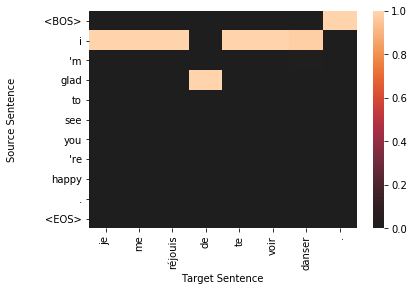

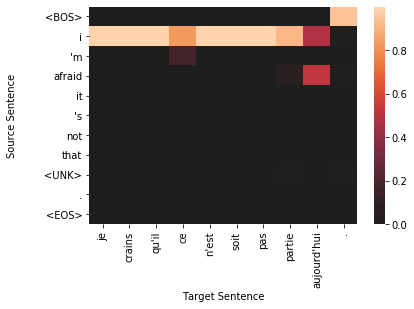

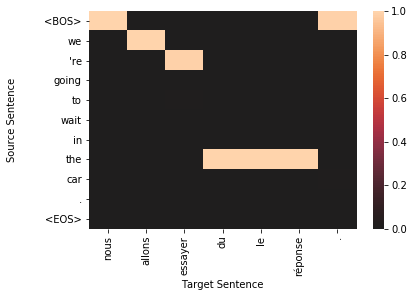

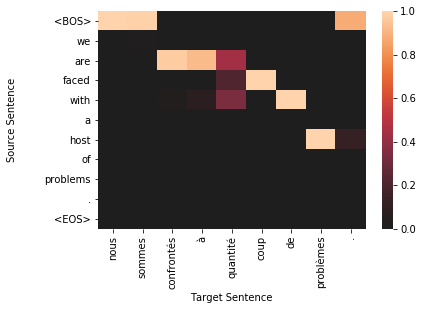

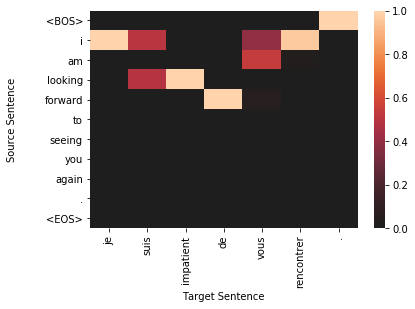

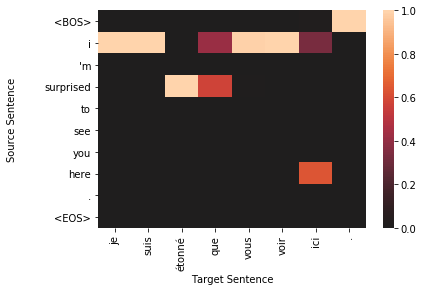

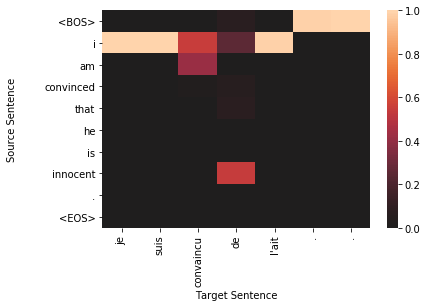

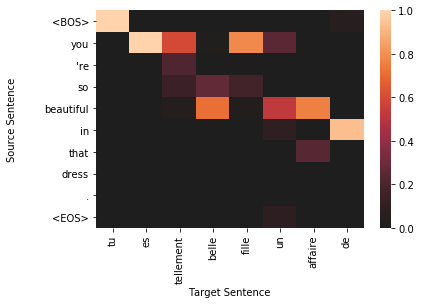

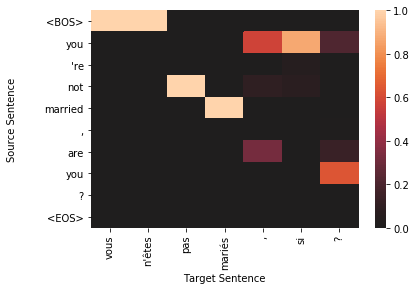

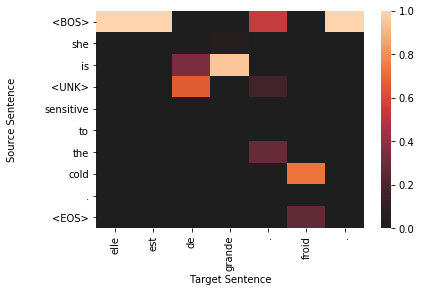

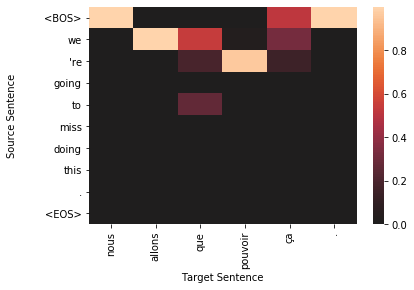

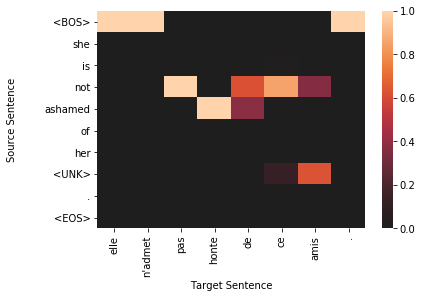

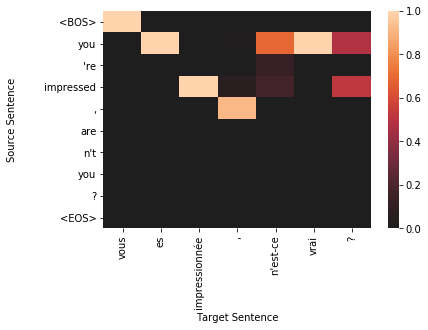

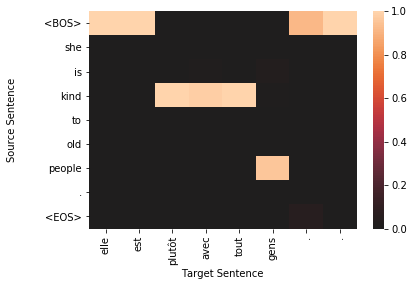

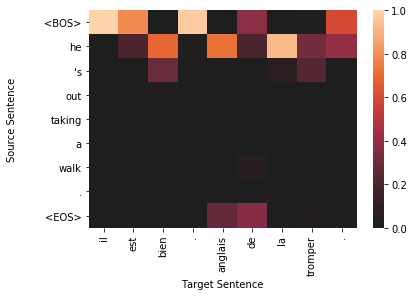

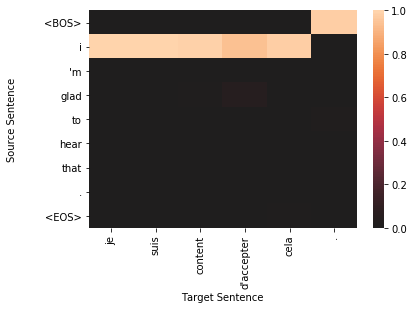

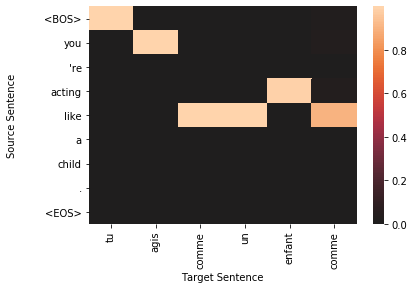

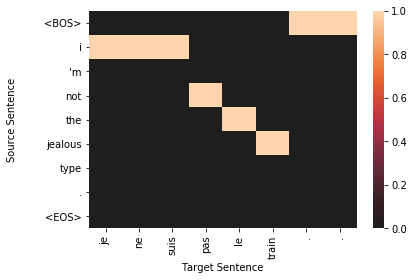

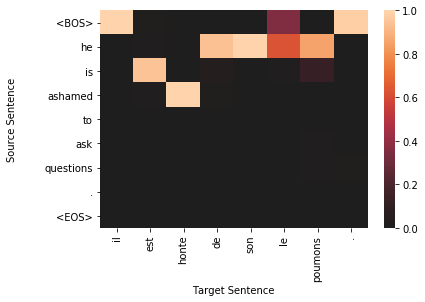

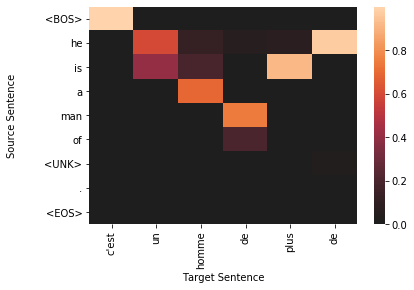

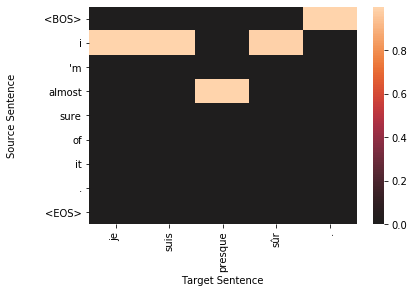

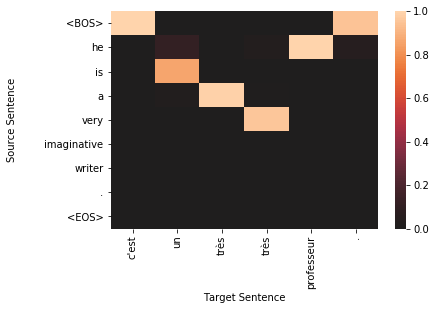

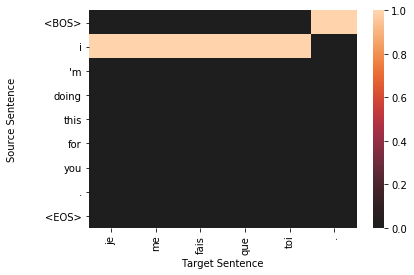

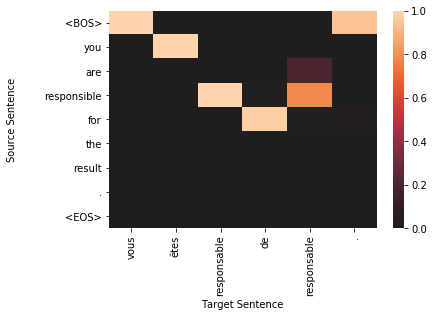

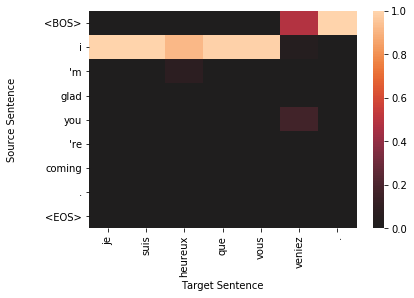

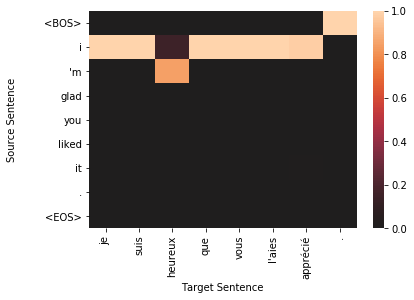

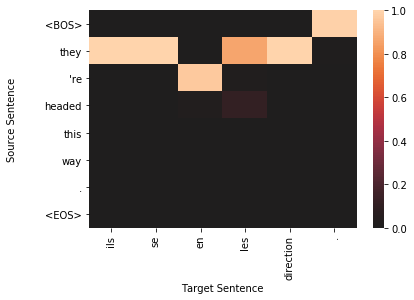

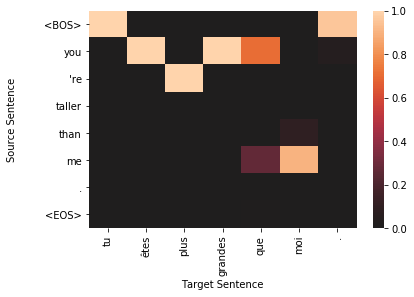

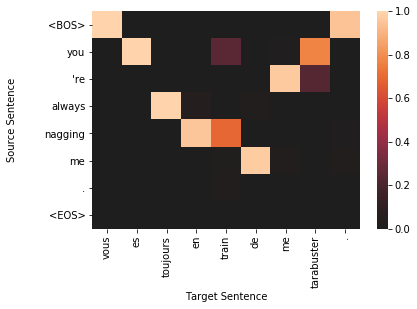

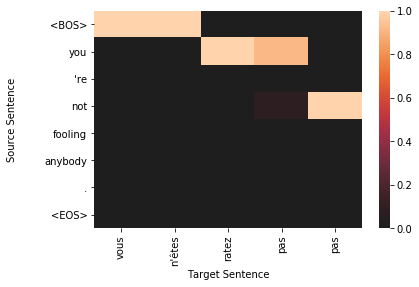

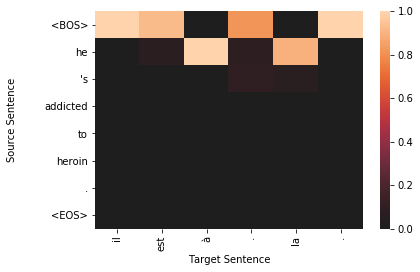

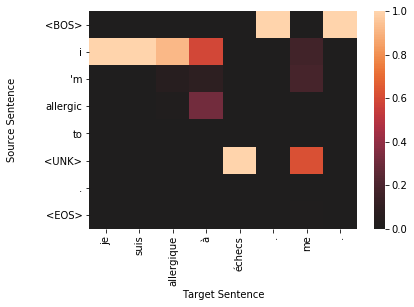

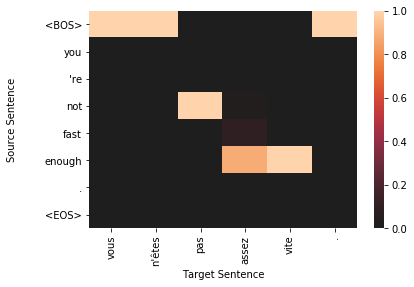

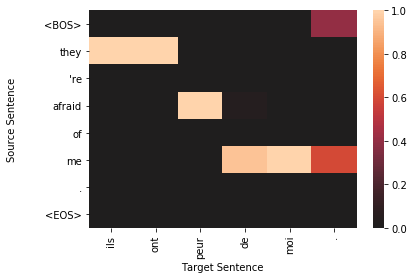

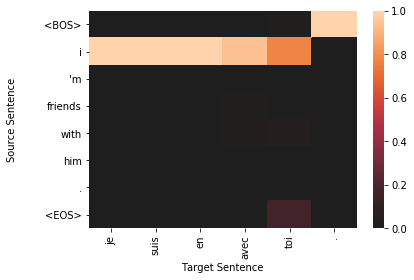

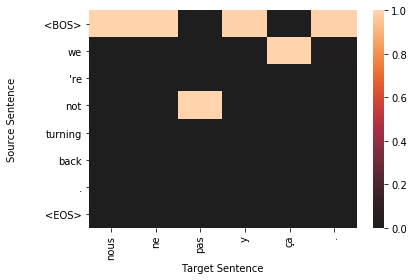

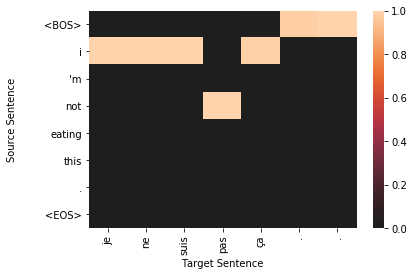

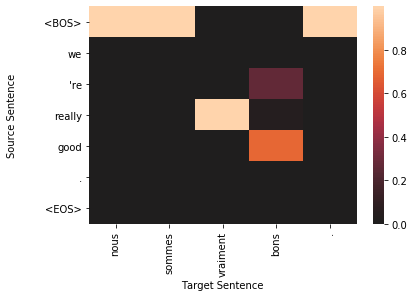

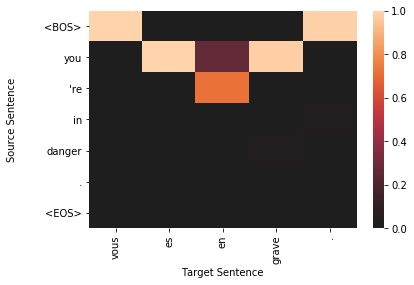

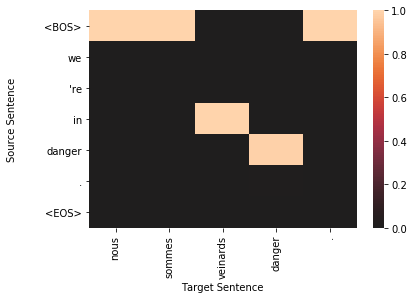

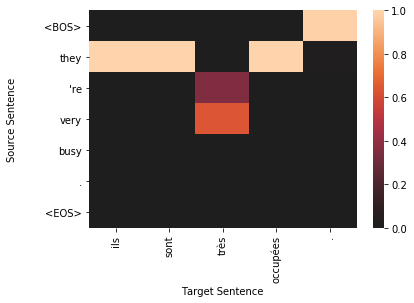

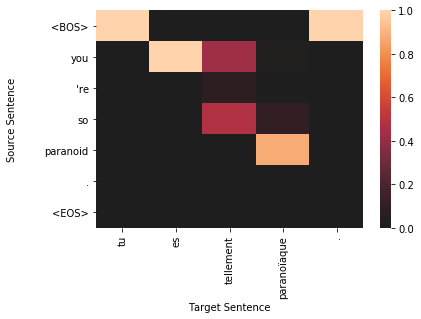

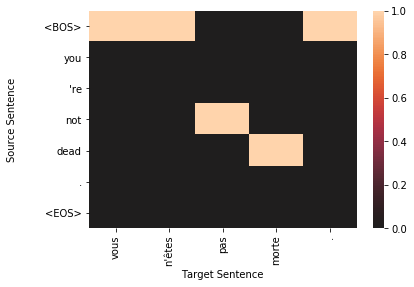

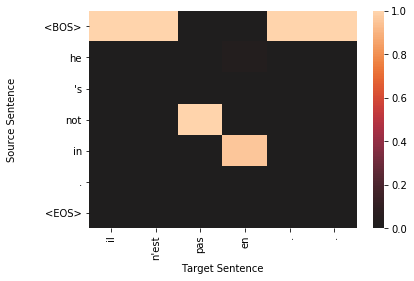

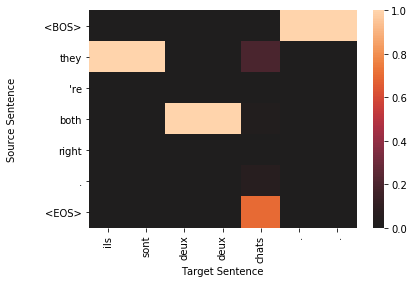

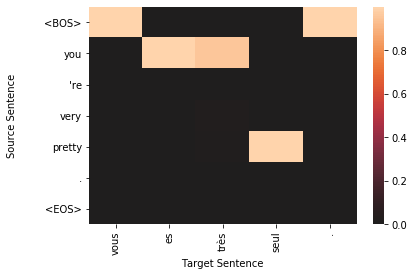

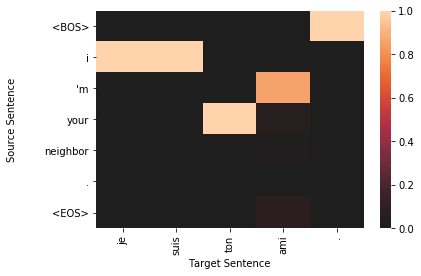

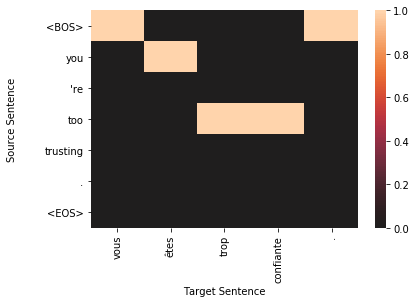

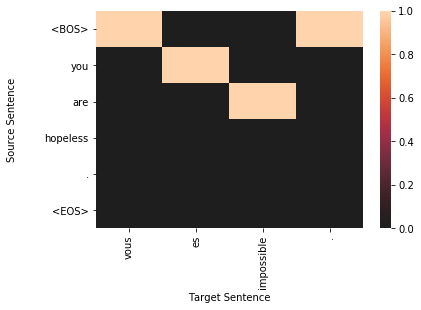

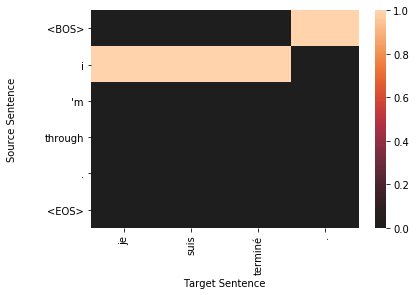

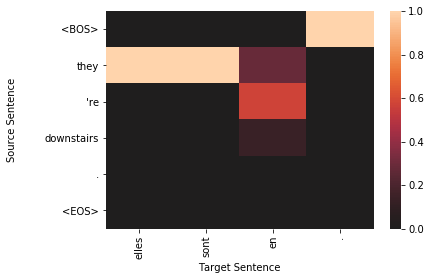

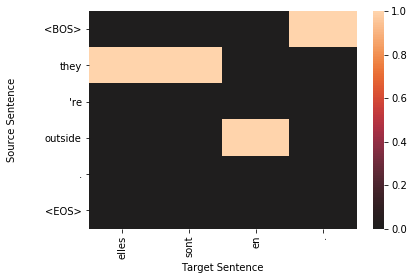

In [64]:
for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])

    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()#[::-1]
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+["<EOS>"]
    #ylabs = sample['source']
    #ylabs = ylabs[::-1]
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel("Source Sentence\n\n")

In [66]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'])
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

results = get_all_sentences(vectorizer, batch_dict, 10)
results

{'source': "i 'm afraid it 's not that <UNK> .",
 'truth': 'je crains que ce ne soit pas si simple .',
 'sampled': "je n'ai qu'il ce n'est soit pas plus bien ."}